In [1]:
import zarr
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from rich import print
from pathlib import Path
from omegaconf import OmegaConf
from dataclasses import dataclass
from alive_progress import alive_it
from sortedcontainers import SortedList
from walrus_workshop.utils import get_key_value_from_string
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.model import load_sae
from walrus_workshop.metrics import compute_enstrophy, compute_deformation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


In [2]:
@dataclass
class Feature:
    index: int
def plot_feature(feature, data_chunk, with_simulation=False, verbose=False, simulation_field=0):
    """ Plot feature """
    if verbose:
        print(f"Plotting feature {feature.index}")
    activations = data_chunk.code[:, feature.index].reshape(-1, 32, 32)
    vmax = np.max(np.abs(activations))
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    for i in range(data_chunk.n_timesteps):
        ax = axs[i // 3, i % 3]
        cb = ax.imshow(activations[i], cmap='hot', vmin=0, vmax=vmax)
        fig.colorbar(cb, ax=ax, shrink=0.5)
        if with_simulation:
            ax.contour(np.linspace(-0.5, activations.shape[1]+0.5, data_chunk.simulation.shape[2]), 
            np.linspace(-0.5, activations.shape[2]+0.5, data_chunk.simulation.shape[1]), 
            data_chunk.simulation[i, ..., simulation_field], levels=1, colors='lavender')
        # ax.set_title(f"Step {data_chunk.step + i}"); ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    plt.show()

In [6]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trajectory
trajectory_id = 51 #63 #50 #63
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

In [16]:
# List of interesting features from the first 
feature_list = [Feature(index=3809), Feature(index=7130), Feature(index=8594), Feature(index=14056), Feature(469)]

Step index 2 = step 6

Opening activation file step_0006_traj_51_Reynolds_1e+05_Schmidt_5e-01_layerblocks.20.space_mixing.activation

Simulation chunk shape: torch.Size([6, 256, 512, 5])

Total deformation

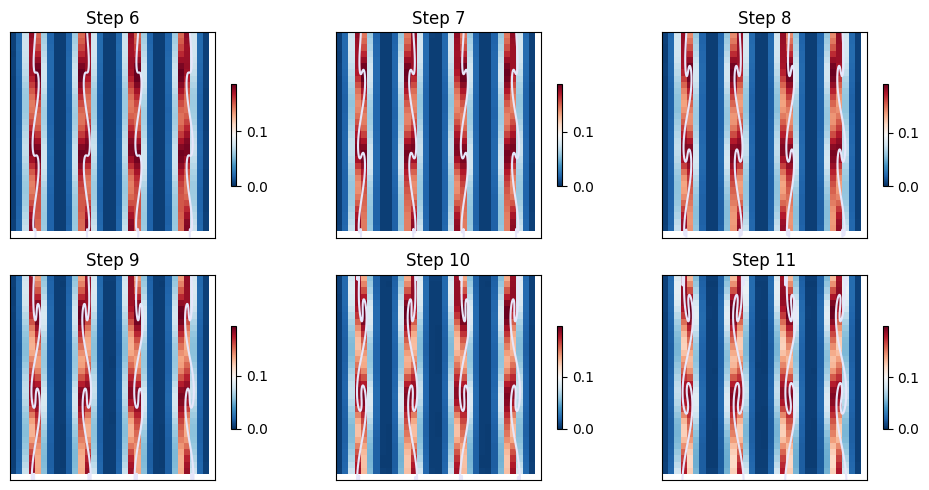

In [19]:
@dataclass
class DataChunk:
    step: int
    n_features: int
    n_timesteps: int
    simulation: np.ndarray
    code: np.ndarray
    total_deformation: np.ndarray

def get_data_chunk(step, verbose=False, plot=False):

    # Get SAE features
    if verbose:
        print(f"Opening activation file {Path(act_files[step_index]).stem}")
    assert get_key_value_from_string(Path(act_files[step_index]).stem, "step") == step # make sure we are processing the same step
    act = zarr.open(act_files[step_index], mode="r")
    act = torch.from_numpy(np.array(act)).to(device)
    with torch.no_grad():
        _, code, _ = sae_model(act)
    code = code.cpu().numpy()

    # Get simulation chunk
    simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input, :, :, 0, :]
    if verbose:
        print(f"Simulation chunk shape: {simulation_chunk.shape}")

    scale_x = int(simulation_chunk.shape[2] / 32)  # width
    scale_y = int(simulation_chunk.shape[1] / 32)  # height
    total_deformation = np.zeros((simulation_chunk.shape[0], 32, 32)) # 32x32 grid of total deformation

    for i in range(simulation_chunk.shape[0]):
        for ix in range(32):
            for iy in range(32):
                token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
                total_deformation[i, iy, ix] = np.sqrt(np.mean(compute_deformation(token[:, :, 2], token[:, :, 3])[0]))

    data_chunk = DataChunk(step=step, n_features=code.shape[1], n_timesteps=simulation_chunk.shape[0], simulation=simulation_chunk, code=code, total_deformation=total_deformation)

    if plot:
        if verbose:
            print("Total deformation")
        fig, axs = plt.subplots(2, 3, figsize=(10, 5))
        for i in range(data_chunk.n_timesteps):
            ax = axs[i // 3, i % 3]
            vmax = np.max(np.abs(data_chunk.total_deformation[i]))
            cb = ax.imshow(data_chunk.total_deformation[i], cmap="RdBu_r", vmin=0, vmax=vmax)
            fig.colorbar(cb, ax=ax, shrink=0.5)
            ax.set_title(f"Step {step + i}"); ax.set_xticks([]); ax.set_yticks([])

            ax.contour(np.linspace(-0.5, data_chunk.total_deformation.shape[1]+0.5, data_chunk.simulation.shape[2]), 
                np.linspace(-0.5, data_chunk.total_deformation.shape[2]+0.5, data_chunk.simulation.shape[1]), 
                data_chunk.simulation[i, ..., 0], levels=1, colors='lavender')    
        fig.tight_layout()
        plt.show()

    return data_chunk


step_index = 2
step = steps[step_index]
print(f"Step index {step_index} = step {step}")
data_chunk = get_data_chunk(step, verbose=True, plot=True)

Plotting feature 3809

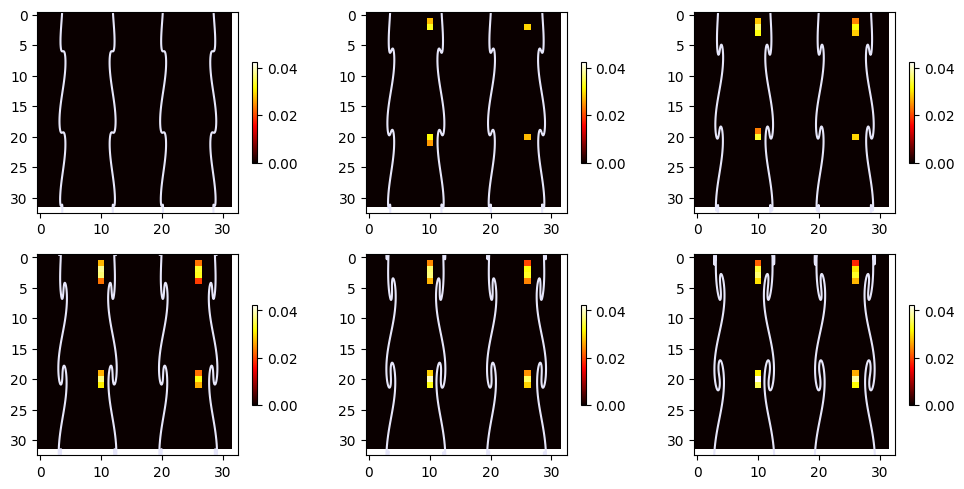

In [20]:
plot_feature(feature_list[0], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

Plotting feature 7130

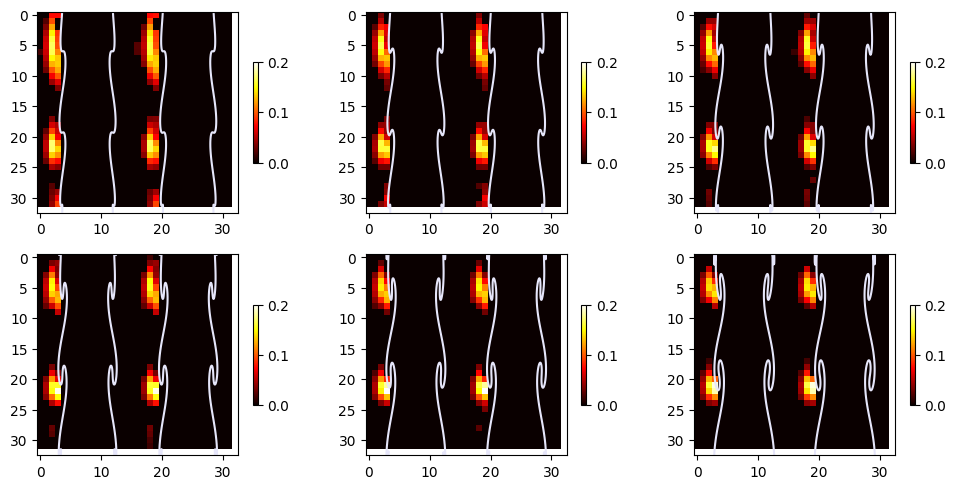

In [21]:
plot_feature(feature_list[1], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

Plotting feature 8594

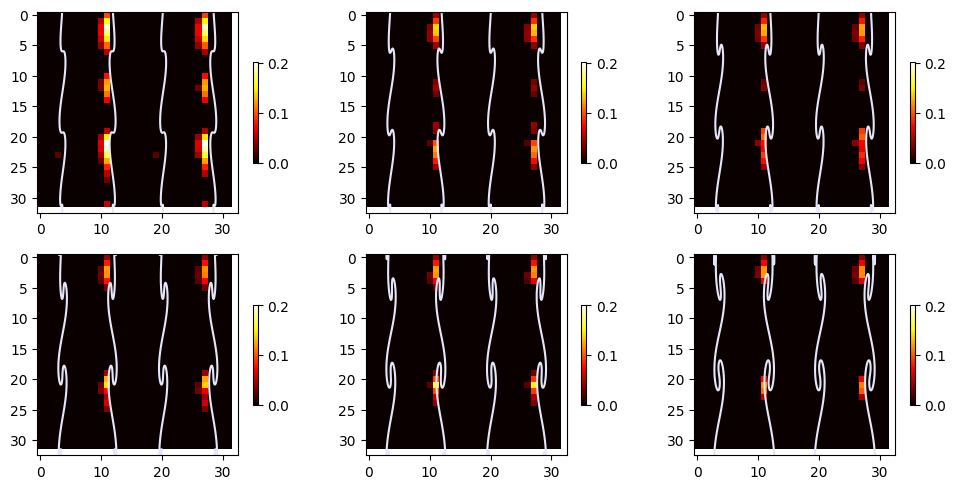

In [22]:
plot_feature(feature_list[2], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

Plotting feature 14056

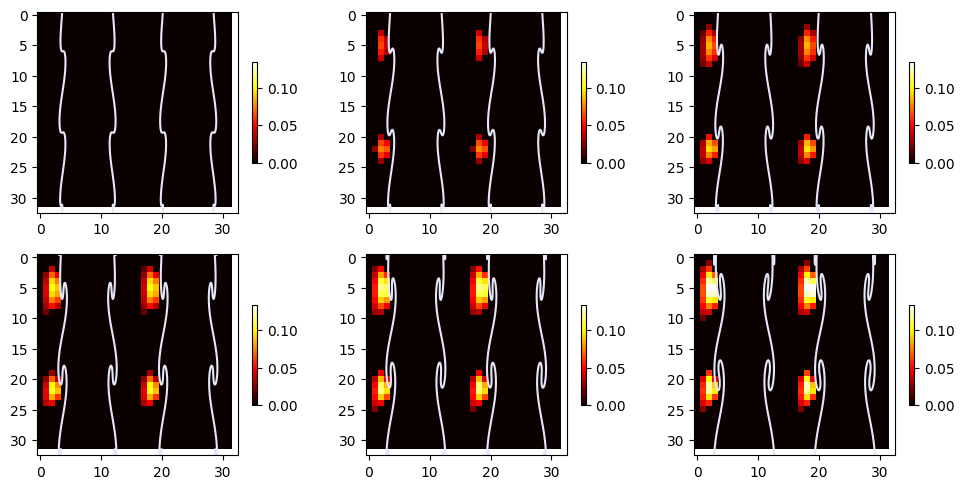

In [23]:
plot_feature(feature_list[3], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

Plotting feature 469

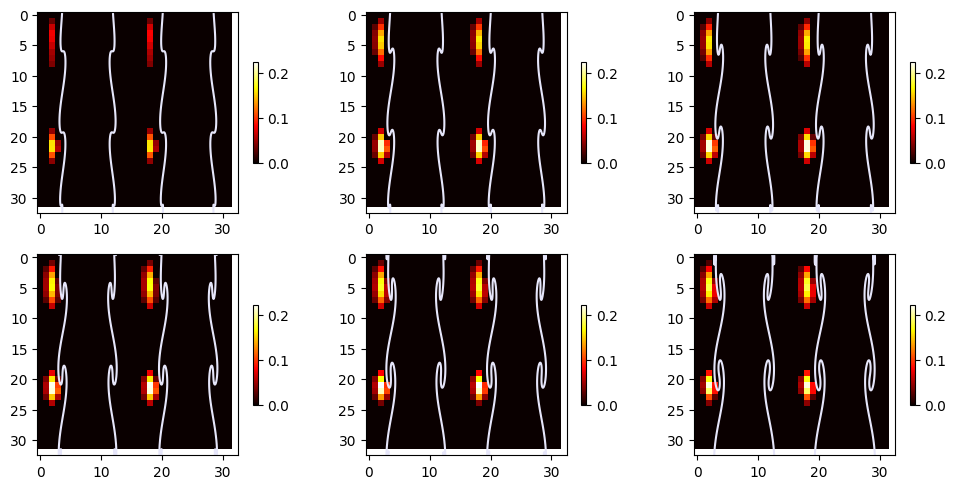

In [24]:
plot_feature(feature_list[4], data_chunk, verbose=True, with_simulation=True, simulation_field=0)